### APRENDIZAJE PROFUNDO PARA PROCESAMIENTO DE INFORMACIÓN BIOMÉTRICA

# Práctica: Biometría Facial
### GRUPO 
* Hajar Boulehdid
* Sofía Santos Schmick
* Andrés Teruel Fernández

---


## Introducción
La biometría facial es un campo de la inteligencia artificial y el aprendizaje profundo con aplicaciones que van desde la verificación de identidad hasta la clasificación de atributos demográficos, como el género y la etnia. Sin embargo, la precisión y equidad de estos sistemas pueden verse afectadas por sesgos en los datos de entrenamiento.

El objetivo principal de este trabajo es estudiar cómo se trabajan con rasgos biométricos, realizar análisis sobre estos e implementar modelos para evaluar el impacto del sesgo en la clasificación de atributos faciales. En particular, se investigará cómo la composición étnica de los datos de entrenamiento influye en el rendimiento de los modelos de clasificación de género. Para ello, se explorará el uso de modelos preentrenados, como ResNet-50, para extraer características faciales (embeddings), que posteriormente serán utilizadas en la construcción de clasificadores de atributos demográficos. 

El primer paso es poner a punto el sistema para garantizar el correcto funcionamiento de la práctica. Para ello, es necesario crear un nuevo entorno con las siguientes versiones de librerías:
* Keras: 2.10.0
* Keras-Processing: 1.1.2
* TensorFlow: 2.10.1
* OpenCV: 4.10.0
* NumPy: 1.26.4

Una vez configurado el entorno con estas versiones, se procede a ejecutar el archivo `face_recognition_main.py`, en el cual se importan todas las librerías y funciones necesarias para el desarrollo de esta práctica.

In [1]:
import os
import numpy as np

# Remove most annoying tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from face_recognition_main import *

---

## Carga de los datos

En esta sección utilizamos la función **load_datasets()** para la carga de dos conjuntos de datos que utilizaremos a lo largo de toda la práctica. Estos datasets estan formados por embeddigs de imágenes faciales procedentes de DiveFace.

Dichos datasets ya están preprocesados y guardados en dos archivos *pickle* para acelerar la ejecución del notebook.

In [2]:
embeddings_10_ppl_dataset, main_embeddings_dataset = load_datasets()

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.


---

## Tarea 1.0: Comparación de Imágenes para Verificación de Identidad
En esta tarea, vamos a comparar varias imágenes faciales para determinar si pertenecen o no a la misma identidad. El objetivo es revisar y entender el código proporcionado, y luego aplicarlo para comparar imágenes y verificar si corresponden a la misma persona.

In [3]:
def compare_images(img_path1, img_path2, threshold=0.5):
    """ Compara dos imágenes y devuelve si pertenecen a la misma persona """
    
    f1 = extract_features(img_path1, True)
    f2 = extract_features(img_path2, True)
    
    similarity = np.dot(f1, f2)
    
    if similarity >= threshold:
        print(f"Las imágenes pertenecen a la misma persona con similitud {similarity:.2f}")
        return True
    else:
        print(f"Las imágenes pertenecen a diferentes personas con similitud {similarity:.2f}")
        return False

In [4]:
"""Comparamos si son la misma persona a través de una simple.Detectamos las caras de las imagenes."""
images_dir = os.path.join('..', 'data', 'imagenes')
images = [os.path.join(images_dir, f"{i}.jpg") for i in range(4)]

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        image1 = images[i]
        image2 = images[j]
        
        print(f"Image {i} vs image {j}: ", end='')
        compare_images(image1, image2)

Image 0 vs image 1: Las imágenes pertenecen a la misma persona con similitud 0.61
Image 0 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.33
Image 0 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.36
Image 1 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.38
Image 1 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.24
Image 2 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.21


En el directorio data/imagenes/ tenemos las siguientes imágenes con sus respectivas identidades:

* **0.jpg**: Albert Einstein
* **1.jpg**: Albert Einstein
* **2.jpg**: Nikola Tesla
* **3.jpg**: Stephen Hawking

El primer paso en la comparación es extraer los vectores de características faciales (embeddings). Luego, se evalúa la similitud entre los embeddings de dos imágenes y, si esta supera un umbral predefinido (0.5 en este caso), se considera que ambas imágenes pertenecen a la misma persona.  

Para medir la similitud, se utiliza el producto punto entre los embeddings, una métrica que refleja el grado de alineación entre los vectores en el espacio. Dado que los embeddings representan características en un espacio de alta dimensión, vectores más cercanos corresponden a rostros más similares.


Teniendo esto en cuenta, podemos observar que, al comparar todas las imágenes entre sí, la extracción de características y el cálculo de similitudes funcionan correctamente. Esto se debe a que el sistema solo identifica que las imágenes **0.jpg y 1.jpg** corresponden a la **misma persona** (Albert Einstein), ya que la similitud entre sus embeddings supera el umbral de 0.5. Por otro lado, las comparaciones entre las demás imágenes (que corresponden a personas diferentes) no superan este umbral, lo que confirma que el sistema está funcionando como se esperaba.

---

## Tarea 1.1: Generación de una Base de Datos y cálculo de FAR y FRR
Ahora vamos a utilizar un pequeño dataset que hemos generado; dicho datset consiste en 5 embeddings por persona y un total de 10 personas. 

Vamos a calcular las curvas de Tasa de Aceptación Falsa (FAR) y Tasa de Rechazo Falsa (FRR), junto con un histograma con las similitudes calculadas para cada impostores y genuinos, además de la curva ROC asociada.


In [5]:
# Dados los embeddings, generar dos arrays con los scores obtenidos 
# y la etiqueta real.
scores, y_true = retrieve_scores_and_true_labels(embeddings_10_ppl_dataset)

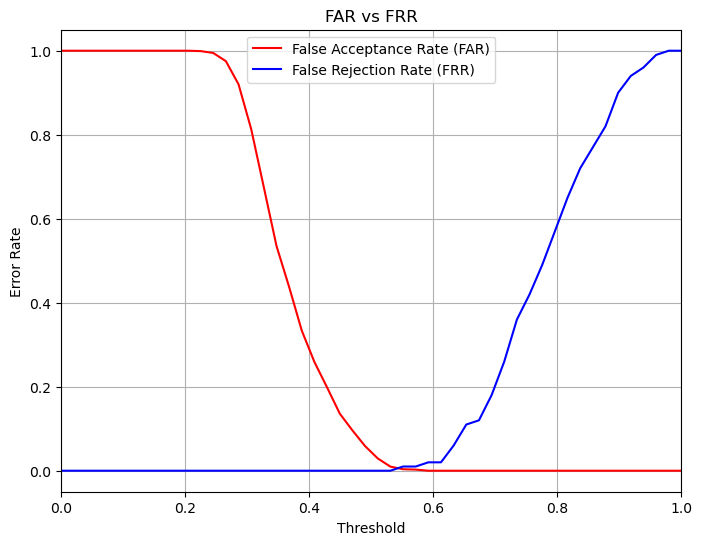

In [6]:
# Generar FAR, FRR y el gráfico
plot_far_frr_curves(scores, y_true)

Se conoce como **FAR (False Acceptance Rate)** al porcentaje de veces que el sistema identifica incorrectamente a dos personas diferentes como si fueran la misma. En otras palabras, representa la proporción de **falsos positivos**, donde el sistema acepta una identidad errónea. Por otro lado, el **FRR (False Rejection Rate)** es el porcentaje de veces que el sistema no reconoce correctamente a una persona como sí misma, es decir, la proporción de **falsos negativos**, donde el sistema rechaza una identidad que verdaderamente es correcta.

Al analizar las curvas de **FAR** y **FRR**, se observa que el área de intersección entre ambas es muy reducida y se encuentra en un intervalo limitado (0.5, 0.6). Esto es deseable en un modelo de reconocimiento biométrico, ya que permite establecer un umbral óptimo que minimice ambas tasas de error. Además, una intersección pequeña indica que, aunque sacrifiquemos alguna de las dos tasas en favor de la otra, el sacrificio no será demasiado grande. 

Los resultados obtenidos sugieren que el modelo es altamente competente en la comparación e identificación de personas. No obstante, es importante señalar que esta evaluación se ha realizado con un conjunto de datos limitado a solo 10 individuos, por lo que no es una comparativa suficientemente amplia para calificar el rendimiento del modelo de manera definitiva. Aun así, los resultados obtenidos son muy notables.

A continuación, vamos a analizar representamos gráficamente la distribución de estos valores de similitud.

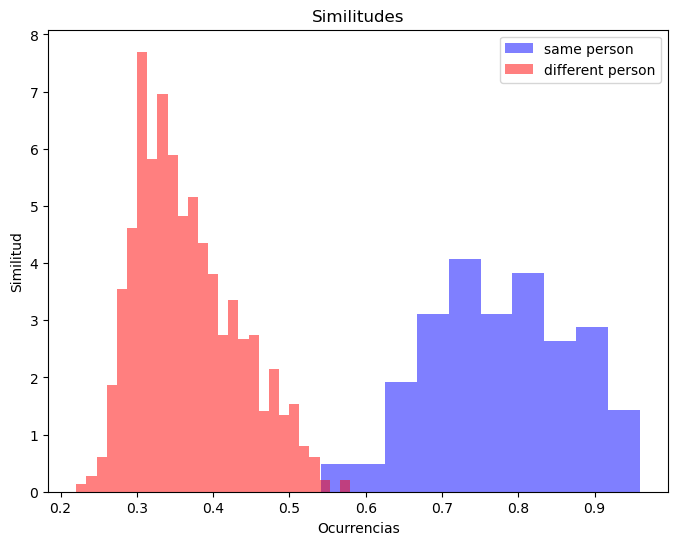

In [7]:
# Generar el histograma de similitudes
plot_similitude_histogram(scores, y_true)

Los histogramas de similitudes entre imágenes de la misma persona y de personas diferentes nos confirman el un intervalo para el umbral óptimo que podíamos intuir en las curvas FAR y FRR, dicho intervalo se encuentra entre el 0.53 y el 0.58. Hay un solapamiento entre las similitudes muy pequeño indicando, al igual que con las curvas FAR y FRR, que si escogemos un umbral en el extremo del intervalo de solapamiento no obtendremos tasas muy grandes de falsa aceptación o de falso rechazo.

Los histogramas están normalizados para hacer una mejor comparación puesto que verdaderamente hay muchas más comparaciones de personas diferentes que de la misma persona, de forma que la curva roja quedaría mucho más grande que la azul.

Al igual que con las curvas FAR y FRR, es importante ser cautelosos con la interpretación de los resultados, ya que el estudio se ha realizado con imágenes de solo 10 personas. Para evaluar el modelo de manera más rigurosa, sería necesario realizar un análisis con un conjunto de datos mucho más amplio.

 ¿MUY ESCALONADO?

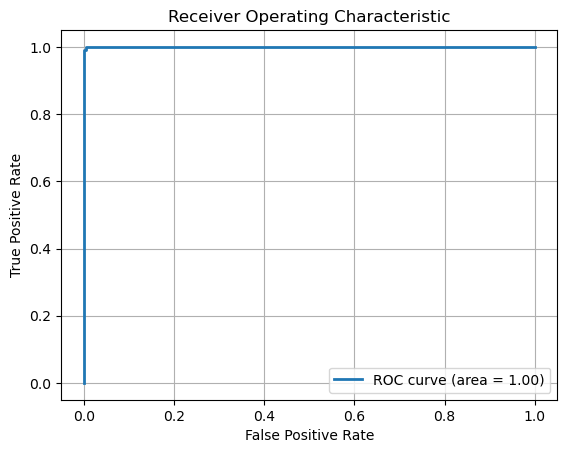

In [8]:
# Generar la curva ROC
plot_roc_curve(scores, y_true)

### Falta comentar la curva roc

---

## Tarea 1.2: Base de Datos DiveFace
A continuación, se va a leer la base de datos DiveFace y extraer los embeddings de 50 imágenes faciales (1 imagen por sujeto) de los 6 grupos demográficos (50 * 6 = 300 embeddings en total). La base de datos DiveFace contiene imágenes faciales de 3 grupos étnicos y 2 géneros, lo que resulta en 6 grupos demográficos.

In [9]:
# Llamar a la función para crear la base de datos de embeddings
embeddings_db_demographic = create_embeddings_subset(main_embeddings_dataset, 350)

# Verificar la cantidad de embeddings por grupo
for group_name, embeddings in embeddings_db_demographic.items():
    print(f"{group_name}: {len(embeddings)} embeddings")

MN4K_120: 350 embeddings
HN4K_120: 350 embeddings
MB4K_120: 350 embeddings
HB4K_120: 350 embeddings
HA4K_120: 350 embeddings
MA4K_120: 350 embeddings


Como observamos en la salida de la celda, hemos obtenido los embeddigs de 350 personas de los 6 grupos demográficos: Negros (Mujeres, Hombres), Blancos (Mujeres, Hombres), Asiáticos (Mujeres, Hombres).

---

## Tarea 1.3: t-SNE
En esta tarea se va a utilizar la técnica de reducción de dimensionalidad t-SNE para visualizar los embeddings extraídos en la Tarea 1.2 y analizar si es posible diferenciar los diferentes grupos demográficos.

El **t-SNE (t-Distributed Stochastic Neighbor Embedding)** es una técnica de reducción de dimensionalidad utilizada para visualizar datos de alta dimensión en un espacio de dos o tres dimensiones (en nuestro caso, dos). Su principal ventaja es que preserva las relaciones locales entre los puntos de datos, lo que la hace especialmente útil para identificar patrones y estructuras en los datos.


En nuestro caso, vamos a aplicar la técnica t-SNE para visualizar los embeddings de las caras para ver cómo se agrupan estos embeddings en función de dos criterios: primero por etnia , y luego por etnia y sexo. Esto nos permitirá analizar la distribución de los embeddings y evaluar posibles patrones en la representación de las caras.



In [10]:
def apply_tsne(embeddings_db):
    """Aplica t-SNE a los embeddings y los visualiza según su grupo étnico y género"""
    
    embeddings_list = []
    labels_list = []
    
    # 6 grupos según etnia y género
    group_mapping = {'HA': 0, 'MA': 1, 'HN': 2, 'MN': 3, 'HB': 4, 'MB': 5}  
    
    # Guardar los embeddings mappeados con su etiqueta
    for group_name, embeddings in embeddings_db.items():
        ethnic_group = group_name[:2]  # Primeras dos letras indican grupo
        label = group_mapping[ethnic_group]  # Obtener la etiqueta del grupo
        
        for emb in embeddings:
            if isinstance(emb, np.ndarray) and emb.shape[0] > 0:  
                embeddings_list.append(emb)
                labels_list.append(label)

    # Convertir la lista a una matriz numpy
    embeddings_matrix = np.vstack(embeddings_list)

    labels_array = np.array(labels_list)
 
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, random_state=40)
    embeddings_2d = tsne.fit_transform(embeddings_matrix)
    
    return embeddings_2d, labels_array

In [11]:
# Aplicar t-SNE a los embeddings
embeddings, labels_array = apply_tsne(embeddings_db_demographic)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


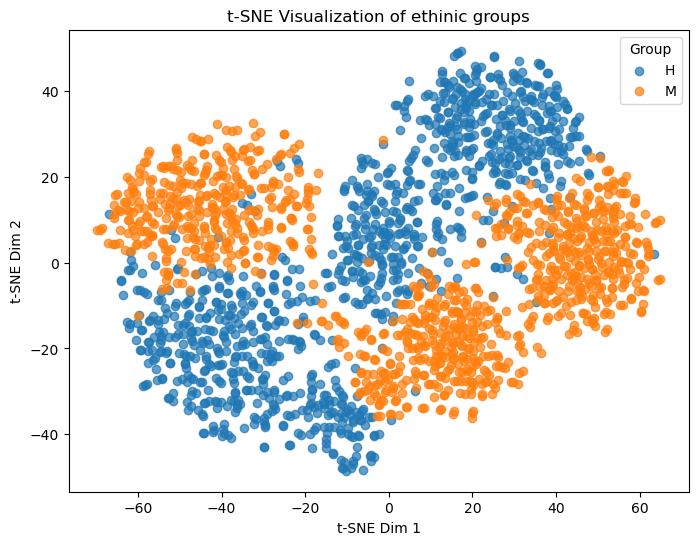

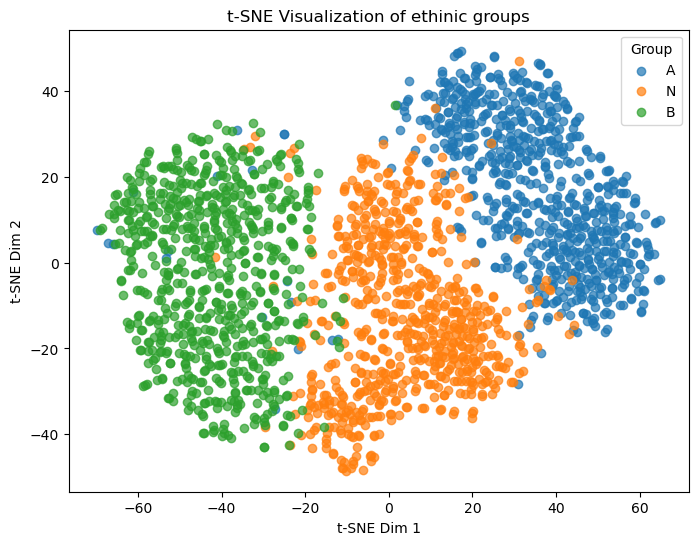

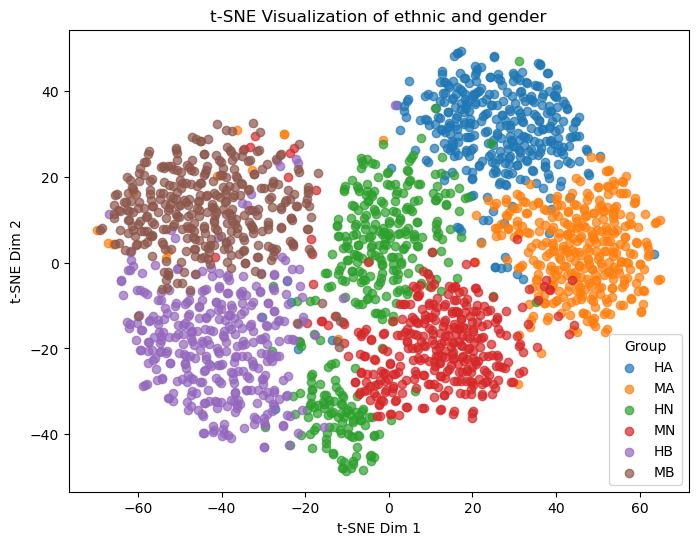

In [12]:
plot_tsne_with_gender(embeddings, labels_array)
plot_tsne_with_ethnic(embeddings, labels_array)
plot_tsne_complete(embeddings, labels_array)

En la **primera figura**, se observan **tres grupos bien diferenciados**, correspondientes a las tres etnias separadas. Esto indica que el modelo ha logrado extraer y codificar características faciales distintivas de cada etnia de forma intrínseca en los embeddings. Sin embargo, Como hemos comentado en alguna lección, se aprecian algunas franjas significativas entre las diferentes etnias provenientes de un **sesgo en la base de datos**, puesto que **individuos mestizos** cuya clasificación es complicada han sido **eliminados** directamente de la base de datos. 

Otro aspecto interesante es que en la **agrupación amarilla** no aparecen puntos de otros colores (excepto en los límites), lo que sugiere que este grupo étnico es difícil de confundir con otro. Sin embargo, sí se observan puntos amarillos infiltrados en otros grupos, lo que indica que individuos de este grupo pueden ser clasificados erróneamente dentro de otras etnias. Esto sugiere una posible **asimetría en la distribución de los datos**, donde ciertos grupos pueden ser más diferenciables que otros.

En la **segunda figura**, los datos muestran una distribución similar a la anterior, pero esta vez con los individuos separados por género. Se observa nuevamente la **división en tres agrupaciones principales** por etnia, y dentro de cada una de ellas, se identifican **subgrupos bien diferenciados**, correspondientes a los géneros masculino y femenino.

Un detalle interesante es que en los **grupos extremos** (izquierda y derecha), los subgrupos de género parecen estar organizados de manera vertical, con uno más arriba y otro más abajo. Sin embargo, en la **agrupación central**, un género presenta componentes en dos áreas distintas, lo que podría indicar una mayor variabilidad en la representación de género dentro de esa etnia. Además, la **agrupación de la izquierda muestra una mayor mezcla en la franja de separación**, lo que sugiere que en ese grupo la diferenciación entre géneros podría ser menos clara.

Finalmente, es importante tener en cuenta que estos resultados pueden estar influenciados por la **aleatoriedad del algoritmo t-SNE**, por lo que podrían variar en ejecuciones distintas. Sin embargo, la tendencia general de separación entre etnias y géneros se mantiene consistente, lo que refuerza la validez de los patrones observados.

---

## Tarea 2.1: Clasificadores de Genéro
En este apartado, entrenaremos tres modelos de clasificación de género, cada uno utilizando imágenes de un único grupo étnico.

* **Modelo A**: Entrenado exclusivamente con imágenes de personas de origen asiático.
* **Modelo B**: Entrenado exclusivamente con imágenes de personas de origen blanco.
* **Modelo N**: Entrenado exclusivamente con imágenes de personas de origen negro.

Cada modelo se entrenará con 1000 imágenes de su respectivo grupo étnico, 500 imágenes por género. Como en los experimentos anteriores, los embeddings se generarán utilizando el modelo preentrenado ``resnet50.h5``.

En primer lugar, dividimos cada grupo de embeddings en un conjunto de entrenamiento (train) y otro de prueba (test) utilizando la función ``generate_test_train``.


In [13]:
embeddings_10_ppl_dataset, main_embeddings_dataset = load_datasets()
embeddings = divide_embeddings(main_embeddings_dataset)

for key, subset in embeddings.items():
    print(key)
    for key2, values in subset.items():
        if "x_" in key2:
            if "train" in key2:
                print(f"Training rows: {len(values)}")
            else: 
                print(f"Testing rows: {len(values)}")

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.
A
Training rows: 1005
Testing rows: 495
B
Training rows: 1005
Testing rows: 495
N
Training rows: 1005
Testing rows: 495


En segundo lugar , creamos un modelo Clasificador de Género basado en embeddings que se define con la arquitectura de una red neuronal artificial simple. Este está compuesta por :
1. **Capa de entrada**. La red recibe un vector de 2048 dimensiones, que corresponde al embedding extraído previamente de la ResNet-50 preentrenada.
2. **Capa oculta**. Tiene 2048 neuronas y usa la función de activación ReLU.
3. **Capa de salida**. Es una capa de clasificación binaria con 2 neuronas, una para cada clase de género. Usa la activación softmax.

En cuanto a la compilacióm, se emplea el optimizador Adam y la función de pérdidas categorical_crossentropy.


A continuación , entrenamos un modelo para cada uno de los grupos étnicos: Asiáticos (Modelo A), Blancos (Modelo B), Negros (Modelo B).

In [14]:
gender_models = {'A': None, 'B': None, 'N': None}

for ethnicity in gender_models.keys():
    gender_models[ethnicity], accuracy, val_accuracy = train_gender_model(
        embeddings[ethnicity]["x_train"], 
        embeddings[ethnicity]["y_train"], 
        embeddings[ethnicity]["x_test"], 
        embeddings[ethnicity]["y_test"]) 
    
    print(f"Model {ethnicity} trained.")

Model A trained.
Model B trained.
Model N trained.


---

## Tarea 2.2: Evaluar Clasificadores de Género
Una vez entrenados los tres modelos en la tarea anterior

 * Evaluate the 3 Gender Classifiers (previous Task 2.1) using images from each of the three ethnic groups.
 * Evaluation: **3 test sets** x **3 models** = **9 accuracies**

La evaluación de los tres modelos se realizará utilizando tanto imágenes del grupo étnico con el que fueron entrenados como imágenes de los demás grupos étnicos. Como métrica se empleará la accuracy.

In [15]:
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N
Dataset A,98.9899,87.2727,94.9495
Dataset B,85.6566,98.5859,87.0707
Dataset N,97.5758,92.3232,98.9899


En la tabla anterior se muestran los resultados obtenidos. Los resultados indican que cada modelo tiene un desempeño excelente cuando se evalúa con imágenes del mismo grupo étnico con el que fue entrenado (valores cercanos al 100%). Sin embargo, el rendimiento disminuye cuando los modelos se prueban con imágenes de otros grupos étnicos. 

Por lo tanto, los modelos podrían estar sobreajustándose a las características específicas de cada grupo étnico, lo que reduciría su capacidad de generalización a otras etnias. Esto pone en evidencia el sesgo empleado en los datos de entrenamiento .
¿Qué modelo generaliza mejor teniendo en cuenta el sesgo?

In [16]:
def predict_gender(model_key, img_path, image=True):
    """
    Realiza la predicción de género a partir de una imagen usando el modelo especificado.
    Parámetros:
    - model_key (str): Clave del modelo a usar ('A', 'B' o 'N').
    - img_path (str): Ruta de la imagen a evaluar.
    Imprime la imagen, la predicción y la clase predicha.
    """
    if model_key not in gender_models:
        print("Error: Modelo no válido. Usa 'A', 'B' o 'N'.")
        return
    
    model = gender_models[model_key]

    # Cargar y mostrar la imagen original
    img = cv2.imread(img_path)
    if img is None:
        print("Error: No se pudo cargar la imagen.")
        return
    # si iamge=True impimir la iamgen
    if image:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(2, 2)) 
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"Imagen de entrada ({model_key})")
        plt.show()
    print(f"\nUsando el modelo '{model_key}':")
    # Extraer la cara de la imagen
    img_face = extract_faces(img_path)

    if img_face is None:
        print("No se detectó ninguna cara en la imagen.")
        return

    # Generar embedding de la cara detectada
    embedding = generate_embedding(img_face)

    if embedding is not None:
        embedding = np.asarray(embedding).reshape(1, -1)  # Asegurar la forma correcta (1, 2048)

        # Usar el modelo correspondiente para la predicción
        prediction = model.predict(embedding, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)

        print(f"\tPredicción mujer: {prediction[0][1]:.05f}")
        print(f"\tPredicción hombre: {prediction[0][0]:.05f}")
        print("\tClase predicha:", "Hombre" if predicted_class[0] == 0 else "Mujer")
    else:
        print("No se pudo generar el embedding de la imagen.")

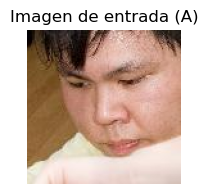


Usando el modelo 'A':
	Predicción mujer: 0.00005
	Predicción hombre: 0.99995
	Clase predicha: Hombre

Usando el modelo 'B':
	Predicción mujer: 0.04428
	Predicción hombre: 0.95572
	Clase predicha: Hombre

Usando el modelo 'N':
	Predicción mujer: 0.00789
	Predicción hombre: 0.99211
	Clase predicha: Hombre


In [17]:
predict_gender('A', '../data/imagenes/2312469191_3.jpg', True)
predict_gender('B', '../data/imagenes/2312469191_3.jpg', False)
predict_gender('N', '../data/imagenes/2312469191_3.jpg', False)

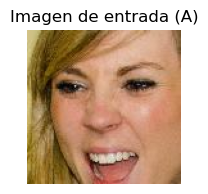


Usando el modelo 'A':
	Predicción mujer: 0.99948
	Predicción hombre: 0.00052
	Clase predicha: Mujer

Usando el modelo 'B':
	Predicción mujer: 1.00000
	Predicción hombre: 0.00000
	Clase predicha: Mujer

Usando el modelo 'N':
	Predicción mujer: 0.99961
	Predicción hombre: 0.00039
	Clase predicha: Mujer


In [18]:
predict_gender('A', '../data/imagenes/5275910717_0.jpg', True)
predict_gender('B', '../data/imagenes/5275910717_0.jpg', False)
predict_gender('N', '../data/imagenes/5275910717_0.jpg', False)

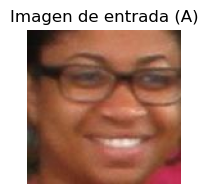


Usando el modelo 'A':
	Predicción mujer: 0.99990
	Predicción hombre: 0.00010
	Clase predicha: Mujer

Usando el modelo 'B':
	Predicción mujer: 0.99470
	Predicción hombre: 0.00530
	Clase predicha: Mujer

Usando el modelo 'N':
	Predicción mujer: 0.99999
	Predicción hombre: 0.00001
	Clase predicha: Mujer


In [19]:
predict_gender('A', '../data/imagenes/7186948655_24.jpg', True)
predict_gender('B', '../data/imagenes/7186948655_24.jpg', False)
predict_gender('N', '../data/imagenes/7186948655_24.jpg', False)

Al probar con un **hombre asiático**, se observa que todos los modelos identifican correctamente el género, aunque para el modelo entrenado con imágenes de asiáticos la precisión es de 0.999, mientras que los otros dos alcanzan aproximadamente un 0.98.

En el caso de la **mujer caucásica**, las predicciones son muy similares entre los modelos; sin embargo, el modelo entrenado con imágenes de blancos parece hacerlo ligeramente mejor, de forma numérica.

Por último, para la **mujer negra** se observa un patrón similar: todos los modelos ofrecen muy buenas predicciones, pero el modelo entrenado con imágenes de negros es el que obtiene los mejores resultados.

Nota: poner algo asi como: vemos que funciona bien tanto en hombres como en mujeres porque hemis usado un dataset equilibrado en cuanto a genero

---

## Tarea 2.3: Clasificador de Genéro
 * Train one Gender Classifiers (previous Task 1.4) using images from all three ethnic groups.


De la misma manera que en el apartado anterior, vamos a a entrenar un modelo Clasificar de Género pero esta vez empleando 1000 embeddings de cada uno de los 3 grupos étnicos.

Primero, dividimos cada grupo de embeddings en un conjunto de train y otro de test haciendo uso de la función `generate_test_train`. Y acontinuación, entrenamos el modelo. 

In [20]:
x_train, x_test, y_train, y_test = generate_test_train(main_embeddings_dataset)

In [21]:
generic_model, accuracy, val_accuracy = train_gender_model(x_train, y_train, x_test, y_test) 
print(f"Generic model trained.")

Generic model trained.


---

## Tarea 2.4: Evaluar todos los Clasificadores de Género
 * Evaluate the Gender Classifier (previous Task 2.3) using images from each of the three ethnic groups.
 * Evaluation: **3 test sets** x **1 models** = **3 accuracies**

Ahora vamos a probar el modelo que generamos anteriormente, evaluando la precisión para cada uno de los grupos étnicos.

In [22]:
gender_models['generic'] = generic_model
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N,Model generic
Dataset A,98.9899,87.2727,94.9495,99.3939
Dataset B,85.6566,98.5859,87.0707,99.7980
Dataset N,97.5758,92.3232,98.9899,99.7980


Podemos observar que el modelo genérico creado tiene una precisión muy alta, superando el 99,66% en cualquier conjunto de datos y alcanzando el 99,8% en el conjunto de datos de los asiáticos.


Model A


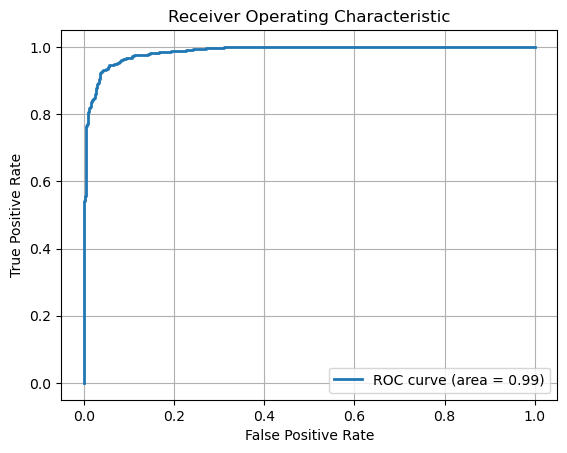

Model B


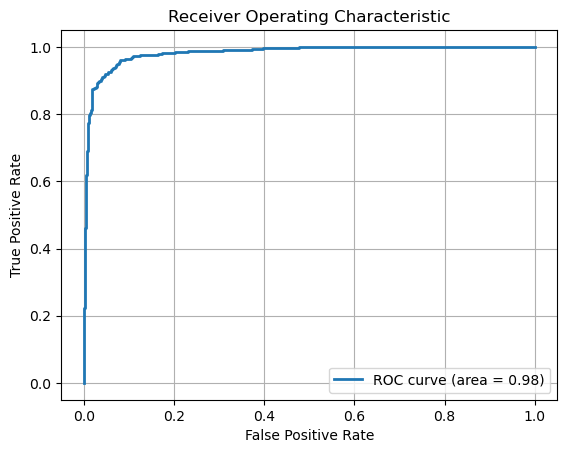

Model N


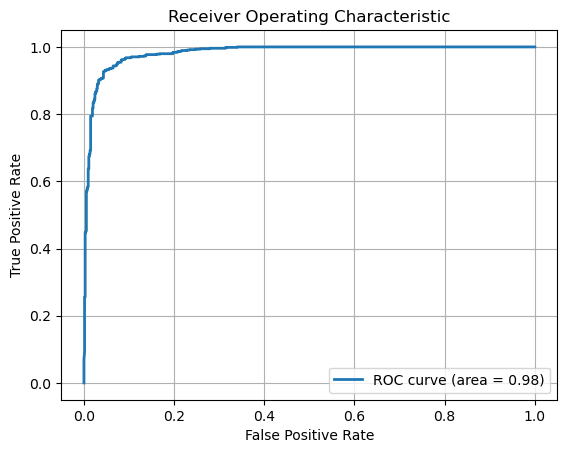

Model generic


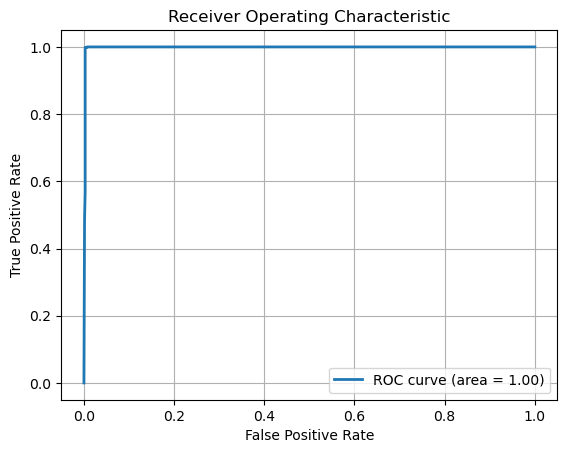

In [23]:
def get_all_roc_curves(gender_models, embeddings):
    for ethnicity, model in gender_models.items():
        print(f"Model {ethnicity}")
        
        predictions = []
        y_true_list = []
        
        for other_ethnicity in embeddings.keys():
            preds = model.predict(embeddings[other_ethnicity]["x_test"], verbose=0)
            predictions.append(preds)
            y_true_list.append(embeddings[other_ethnicity]["y_test"])
        
        # Concatenate the predictions and true labels along the first axis
        all_predictions = np.concatenate(predictions, axis=0)
        all_y_true = np.concatenate(y_true_list, axis=0)

        plot_roc_curve(all_predictions[:, 1], all_y_true[:, 1])

# Generar la curva ROC
get_all_roc_curves(gender_models, embeddings)

## Tarea 2.5 : Clasificador de Género y de Étnia

In [24]:
def generate_test_train2(embeddings_db):
    """
    Convierte un diccionario de embeddings en matrices X e y.
    Parámetros:
    - embeddings_db: dict, diccionario con claves que indican el grupo y valores con listas de embeddings.
 
    Retorna:
    - X: numpy array con los embeddings.
    - y: numpy array con las etiquetas (one-hot encoded) para género y etnia.
    """
    X = []
    y = []
    
    # Definir etiquetas para las 6 clases: 3 etnias x 2 géneros = 6 clases
    for label, embeddings in embeddings_db.items():
        gender = 0 if label[0] == 'H' else 1  # Hombre (0), Mujer (1)
        ethnicity = label[1]  # A = Blanco, B = Asiático, N = Negro
        
        # Asignamos el índice de clase según la etnia y el género
        if ethnicity == 'A':  # Blanco
            ethnicity_label = 0
        elif ethnicity == 'B':  # Asiático
            ethnicity_label = 1
        else:  # Negro
            ethnicity_label = 2
        
        # La etiqueta será una combinación de género y etnia
        label_combined = ethnicity_label * 2 + gender  # 6 clases posibles
        
        for emb in embeddings:
            X.append(emb)
            y.append(label_combined)
 
    X = np.array(X).astype(float)
    y = to_categorical(y, num_classes=6)  # Convertir a one-hot encoding para 6 clases

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
 
    return X_train, X_test, y_train, y_test


In [25]:
def generate_combined_model():
    # Definir el modelo
    model = Sequential([ 
        Dense(2048, activation='relu', input_shape=(2048,)), 
        Dense(6, activation='softmax')  # Capa de salida con 6 clases (combinación de género y etnia)
    ])
    
    # Compilar el modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])
    
    return model


def train_combined_model(x_train, y_train, x_test, y_test):
    model = generate_combined_model()

    history = model.fit(
        x_train, y_train,  
        validation_data=(x_test, y_test),  
        epochs=20,  
        batch_size=32,  
        verbose=0  
    )
    
    return model, history.history['accuracy'][-1], history.history['val_accuracy'][-1]


In [26]:
x_train, x_test, y_train, y_test = generate_test_train2(main_embeddings_dataset)

In [27]:
# Verificar los tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento (x_train): {len(x_train)}")
print(f"Tamaño del conjunto de prueba (x_test): {len(x_test)}")

# Verificar la distribución de clases en y_train (etiquetas)
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de entrenamiento:")
for u, c in zip(unique_train, counts_train):
    print(f"Clase {u}: {c} ejemplos")

# Verificar la distribución de clases en y_test (etiquetas)
unique_test, counts_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de prueba:")
for u, c in zip(unique_test, counts_test):
    print(f"Clase {u}: {c} ejemplos")


Tamaño del conjunto de entrenamiento (x_train): 3015
Tamaño del conjunto de prueba (x_test): 1485
Distribución de clases en el conjunto de entrenamiento:
Clase 0: 503 ejemplos
Clase 1: 502 ejemplos
Clase 2: 502 ejemplos
Clase 3: 502 ejemplos
Clase 4: 503 ejemplos
Clase 5: 503 ejemplos
Distribución de clases en el conjunto de prueba:
Clase 0: 247 ejemplos
Clase 1: 248 ejemplos
Clase 2: 248 ejemplos
Clase 3: 248 ejemplos
Clase 4: 247 ejemplos
Clase 5: 247 ejemplos


In [28]:
combined_model, accuracy, val_accuracy = train_combined_model(x_train, y_train, x_test, y_test)
print(f"Combined model trained.")

Combined model trained.


In [29]:
# Evaluar el modelo en el conjunto de test
test_loss, test_accuracy = combined_model.evaluate(x_test, y_test, verbose=0)

print(f"Accuracy en los datos de prueba: {test_accuracy * 100:.2f}%")


Accuracy en los datos de prueba: 97.37%


In [30]:
def predict_gender_ethnicity(combined_model, img_path, image=True):
    """
    Realiza la predicción de género y etnia a partir de una imagen usando un único modelo combinado.
    Parámetros:
    - combined_model: el modelo entrenado que predice género y etnia.
    - img_path (str): Ruta de la imagen a evaluar.
    Imprime la imagen, la predicción y la clase predicha (género y etnia).
    """
    # Cargar y mostrar la imagen original
    img = cv2.imread(img_path)
    if img is None:
        print("Error: No se pudo cargar la imagen.")
        return
    
    # Si image=True, imprimir la imagen
    if image:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(2, 2)) 
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"Imagen de entrada")
        plt.show()

    print(f"\nUsando el modelo combinado:")
    # Extraer la cara de la imagen
    img_face = extract_faces(img_path)

    if img_face is None:
        print("No se detectó ninguna cara en la imagen.")
        return

    # Generar embedding de la cara detectada
    embedding = generate_embedding(img_face)

    if embedding is not None:
        embedding = np.asarray(embedding).reshape(1, -1)  # Asegurar la forma correcta (1, 2048)

        # Usar el modelo combinado para la predicción
        prediction = combined_model.predict(embedding, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)

        # Mostrar las probabilidades para cada clase
        print(f"\tPredicción para las clases (Género + Etnia):")
        print(f"\tPredicción (HA): {prediction[0][0]:.05f}")
        print(f"\tPredicción (MA): {prediction[0][1]:.05f}")
        print(f"\tPredicción (HB): {prediction[0][2]:.05f}")
        print(f"\tPredicción (MB): {prediction[0][3]:.05f}")
        print(f"\tPredicción (HN): {prediction[0][4]:.05f}")
        print(f"\tPredicción (MN): {prediction[0][5]:.05f}")
        
        # Mostrar la clase predicha (combinación de género y etnia)
        if predicted_class[0] == 0:
            print("\tClase predicha: Hombre Etnia A")
        elif predicted_class[0] == 1:
            print("\tClase predicha: Mujer Etnia A")
        elif predicted_class[0] == 2:
            print("\tClase predicha: Hombre Etnia B")
        elif predicted_class[0] == 3:
            print("\tClase predicha: Mujer Etnia B")
        elif predicted_class[0] == 4:
            print("\tClase predicha: Hombre Etnia N")
        elif predicted_class[0] == 5:
            print("\tClase predicha: Mujer Etnia N")
    else:
        print("No se pudo generar el embedding de la imagen.")


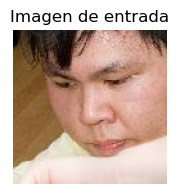


Usando el modelo combinado:
	Predicción para las clases (Género + Etnia):
	Predicción (HA): 0.99998
	Predicción (MA): 0.00002
	Predicción (HB): 0.00000
	Predicción (MB): 0.00000
	Predicción (HN): 0.00000
	Predicción (MN): 0.00000
	Clase predicha: Hombre Etnia A


In [31]:
predict_gender_ethnicity(combined_model, '../data/imagenes/2312469191_3.jpg')


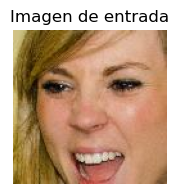


Usando el modelo combinado:
	Predicción para las clases (Género + Etnia):
	Predicción (HA): 0.00000
	Predicción (MA): 0.00000
	Predicción (HB): 0.00000
	Predicción (MB): 1.00000
	Predicción (HN): 0.00000
	Predicción (MN): 0.00000
	Clase predicha: Mujer Etnia B


In [32]:
predict_gender_ethnicity(combined_model, '../data/imagenes/5275910717_0.jpg')


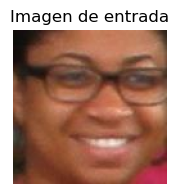


Usando el modelo combinado:
	Predicción para las clases (Género + Etnia):
	Predicción (HA): 0.00000
	Predicción (MA): 0.00000
	Predicción (HB): 0.00000
	Predicción (MB): 0.00000
	Predicción (HN): 0.00000
	Predicción (MN): 1.00000
	Clase predicha: Mujer Etnia N


In [33]:
predict_gender_ethnicity(combined_model, '../data/imagenes/7186948655_24.jpg')

In [34]:
# Nota: podrias cambiar estas imagenes por variar

--- 
## Tarea 2.6 (extra) : Clasificador de Género genérico con Base de Datos sesgada

Se va a emplear un modelo genérico entrenado con los tres grupos étnicos, pero no de manera equitativa sino con una base de datos sesgada en la que habrá más individuos de una étnia que de otras. Esto refleja un escenario real, muchas veces se entrena bases de datos con una distribución desigual de datos, lo que puede llevar a sesgos en el modelo. En este caso, la predominancia de una etnia sobre las otras puede influir en el desempeño del modelo, haciendo que tenga mayor precisión para el grupo mayoritario y menor precisión para los grupos con menor representación.


**Biased Model 1 : 60%, 30%, 10%**

En el entrenamiento de este modelo, como en el de `generic_model`, se va a emplear un total de 3000 embeddings. Con el objetivo de estudiar el efecto que tiene una base de datos sesgada en las predicciones, vamos a entrenar un modelo con un 60% de embeddings pertenecientes a la etnia blanca (1800), un 30% pertenecientes a la etnia asiática (900) y un 10% perteneciente a la etnia negra (300). Cabe destacar que se va a tomar el mismo número de embeddings del género masculino que del femenino. 

In [35]:
_, bias_embedings_dataset = load_datasets()

bias_embedings_dataset['HN4K_120'] = bias_embedings_dataset['HN4K_120'][:5]
bias_embedings_dataset['MN4K_120'] = bias_embedings_dataset['MN4K_120'][:5]

bias_embedings_dataset['HA4K_120'] = bias_embedings_dataset['HA4K_120'][:250]
bias_embedings_dataset['MA4K_120'] = bias_embedings_dataset['MA4K_120'][:250] 

bias_embedings_dataset['HB4K_120'] = bias_embedings_dataset['HB4K_120'][:250]
bias_embedings_dataset['MB4K_120'] = bias_embedings_dataset['MB4K_120'][:250]

x_train, x_test, y_train, y_test = generate_test_train(bias_embedings_dataset)
print(len(x_train), len(x_test), len(x_train) + len(x_test))

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.
676 334 1010


In [36]:
generic_biased_model, accuracy, val_accuracy = train_gender_model(x_train, y_train, x_test, y_test) 
print(f"Generic biased model trained.")

Generic biased model trained.


In [37]:
gender_models['generic_biased1'] = generic_biased_model
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N,Model generic,Model generic_biased1
Dataset A,98.9899,87.2727,94.9495,99.3939,98.7879
Dataset B,85.6566,98.5859,87.0707,99.7980,97.9798
Dataset N,97.5758,92.3232,98.9899,99.7980,97.9798


Se observa que, con el modelo sesgado, se obtiene una mayor accuracy para la etnia blanca (99.60%), lo que coincide con la distribución del entrenamiento, donde esta etnia tuvo una mayor representación en los datos. Para la etnia asiática, la precisión es 99.53%, mostrando un rendimiento similar al de la etnia blanca, aunque ligeramente inferior. Por otro lado, la etnia negra presenta la menor accuracy con 98.73%, probablemente debido a la menor cantidad de datos utilizados en su entrenamiento.

Este resultado pone de manifiesto el impacto del sesgo en los datos de entrenamiento, ya que el modelo tiende a desempeñarse mejor en aquellas clases que han sido más representadas, mientras que su precisión disminuye en aquellas con menor presencia en el conjunto de entrenamiento.

**Biased Model 2 : 80%, %20**

En este caso, se va a entrenar el modelo con un 80% de embeddings de la etnia negra (2400) y un 20% de etnia asiática (600), norrectamente a muestras de otras etnias. De esta manera, podremos evaluar si el modelo es capaz de generalizar correctamente a muestras de otras etnias.

In [38]:
_, bias_embedings_dataset = load_datasets()

bias_embedings_dataset['HN4K_120'] = bias_embedings_dataset['HN4K_120'][:1200]
bias_embedings_dataset['MN4K_120'] = bias_embedings_dataset['MN4K_120'][:1200]

bias_embedings_dataset['HA4K_120'] = bias_embedings_dataset['HA4K_120'][:300]
bias_embedings_dataset['MA4K_120'] = bias_embedings_dataset['MA4K_120'][:300] 

bias_embedings_dataset.pop('HB4K_120', None)
bias_embedings_dataset.pop('MB4K_120', None)

x_train, x_test, y_train, y_test = generate_test_train(bias_embedings_dataset)
print(len(x_train), len(x_test), len(x_train) + len(x_test))

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.
1407 693 2100


In [39]:
generic_biased_model, accuracy, val_accuracy = train_gender_model(x_train, y_train, x_test, y_test) 
print(f"Generic biased model trained.")

Generic biased model trained.


In [40]:
gender_models['generic_biased2'] = generic_biased_model
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N,Model generic,Model generic_biased1,Model generic_biased2
Dataset A,98.9899,87.2727,94.9495,99.3939,98.7879,98.3838
Dataset B,85.6566,98.5859,87.0707,99.7980,97.9798,84.2424
Dataset N,97.5758,92.3232,98.9899,99.7980,97.9798,99.1919


Como era de esperar, el desempeño del modelo sesgado en la etnia blanca es notablemente inferior (85.13%) en comparación con el de las demás etnias, donde alcanza 98.93% en la etnia asiática y 99.26% en la etnia negra.

Model A


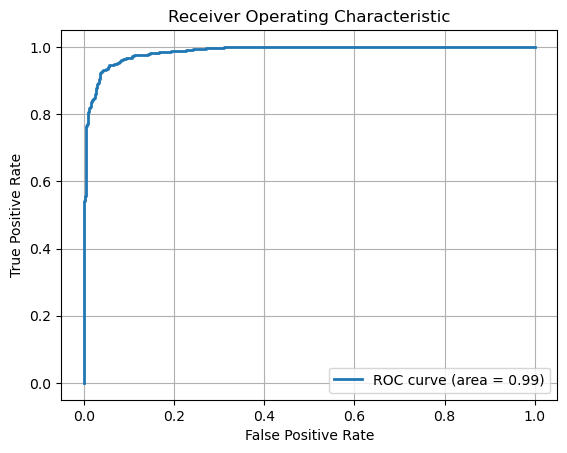

Model B


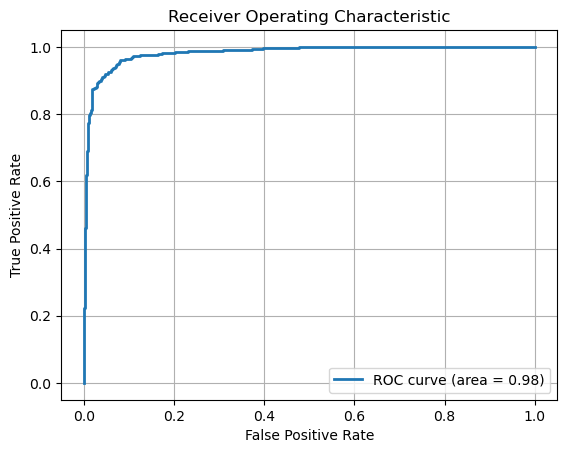

Model N


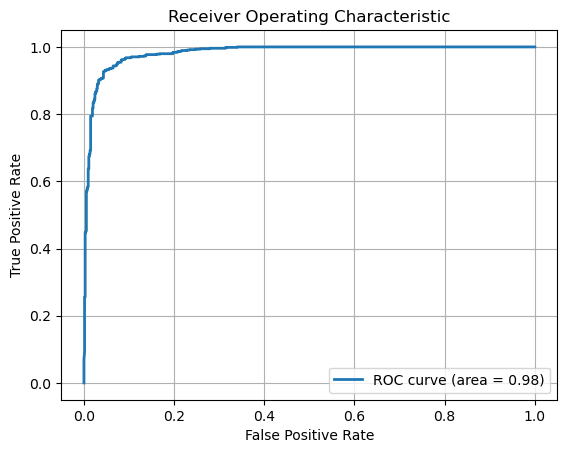

Model generic


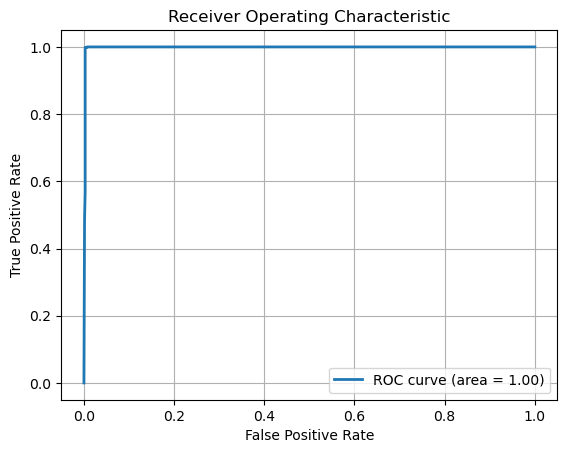

Model generic_biased1


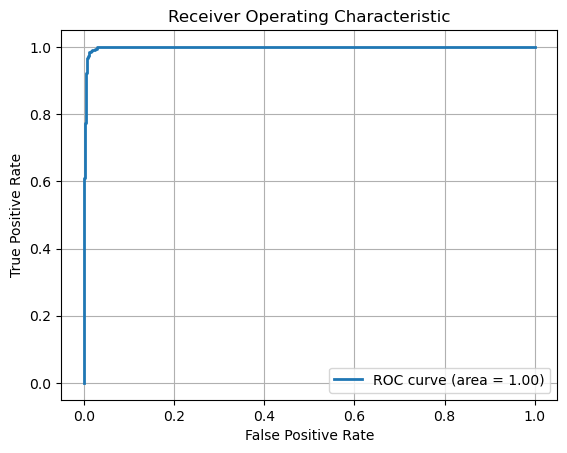

Model generic_biased2


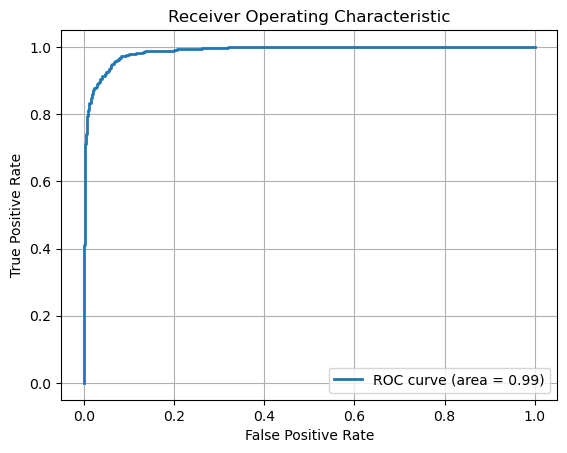

In [41]:
# Generar la curva ROC
get_all_roc_curves(gender_models, embeddings)